<a href="https://colab.research.google.com/github/prossel/MediaPipeTraining/blob/main/object%20detection/object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project: /mediapipe/_project.yaml
Book: /mediapipe/_book.yaml

<link rel="stylesheet" href="/mediapipe/site.css">

# Object detection model customization guide

<table align="left" class="buttons">
  <td>
    <a href="https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/customization/object_detector.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/colab-logo-32px_1920.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/googlesamples/mediapipe/blob/main/examples/customization/object_detector.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/github-logo-32px_1920.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# **This notbook only runs on version 2025.07 (menu Exécution / Modifier le type d'exécution)**

In [7]:
#@title License information
# Copyright 2023 The MediaPipe Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
#
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

The MediaPipe object detection solution provides several models you can use immediately for machine learning (ML) in your application. However, if you need to detect objects not covered by the provided models, you can customize any of the provided models with your own data and MediaPipe Model Maker. This model modification tool rebuilds the model using data you provide. This method is faster than training a new model and can produce a model that is more useful for your specific application.

The following sections show you how to use Model Maker to retrain a pre-built model for object detection with your own data, which you can then use with the MediaPipe [Object Detector](https://developers.google.com/mediapipe/solutions/vision/object_detector). The example retrains a general purpose object detection model to detect android figurines in images.

## Setup

This section describes key steps for setting up your development environment to retrain a model. These instructions describe how to update a model using [Google Colab](https://colab.research.google.com/), and you can also use Python in your own development environment. For general information on setting up your development environment for using MediaPipe, including platform version requirements, see the [Setup guide for Python](https://developers.google.com/mediapipe/solutions/setup_python).

**Attention:** This MediaPipe Solutions Preview is an early release. [Learn more](https://developers.google.com/mediapipe/solutions/about).

To install the libraries for customizing a model, run the following commands:

In [7]:
!python --version

# Check if running in Google Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Google Colab: use default installation
    !pip install --upgrade pip
    !pip install -q mediapipe-model-maker
else:
    # Local environment: install compatible versions for macOS ARM
    print("Running locally - installing for macOS Apple Silicon...")
    print("This may take a few minutes...")
    !pip install --upgrade pip
    
    # Install JAX FIRST with compatible versions for TensorFlow 2.15
    # These versions work together without float8 issues
    !pip install "jax[cpu]==0.4.20" ml-dtypes==0.2.0
    
    # Install core TensorFlow dependencies
    !pip install tensorflow-macos==2.15.0 tensorflow-metal==1.1.0
    !pip install tf-keras==2.15.0
    !pip install tensorflow-hub==0.15.0
    
    # Install mediapipe-model-maker without dependencies to avoid conflicts
    !pip install --no-deps mediapipe-model-maker==0.2.1.3
    
    # Install remaining dependencies that mediapipe-model-maker needs
    !pip install tensorflow-datasets numpy pillow opencv-python matplotlib scikit-learn scipy pycocotools absl-py
    
    print("\n✅ Installation complete!")

Python 3.11.14
Running locally - installing for macOS Apple Silicon...
This may take a few minutes...
Running locally - installing for macOS Apple Silicon...
This may take a few minutes...
  Using cached jax-0.4.20-py3-none-any.whl.metadata (23 kB)
  Using cached jax-0.4.20-py3-none-any.whl.metadata (23 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached jaxlib-0.4.20-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached jaxlib-0.4.20-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.1 kB)
Using cached jax-0.4.20-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl (1.2 MB)
Using cached jaxlib-0.4.20-cp311-cp311-macosx_11_0_arm64.whl (65.0 MB)
Using cached jax-0.4.20-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl (1.2 MB)
Using cached jaxlib-0.4.20-cp3

Use the following code to import the required Python classes:

**Important for local execution:** 
- On Google Colab, this installs the latest compatible versions automatically
- On local macOS (Apple Silicon), this installs specific versions from `requirements.txt` that are compatible with TensorFlow Metal and Python 3.11
- Make sure to restart the kernel after installation if you get import errors

In [1]:
# Check if running in Google Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    # Create a dummy files module for local execution
    class files:
        @staticmethod
        def download(filename):
            print(f"Running locally - file saved at: {filename}")
            print(f"(In Colab, this would trigger a download)")

import os
import json
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import object_detector

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local (macOS)'}")

/Users/pierre.rossel/Documents/Projets/HEAD/2025.10 MD1 Oracle of Suits/The naked card/MediaPipeTraining/.venv311/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/Users/pierre.rossel/Documents/Projets/HEAD/2025.10 MD1 Oracle of Suits/The naked card/MediaPipeTraining/.venv311/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more informa

Environment: Local (macOS)


## Prepare data

Retraining a model for object detection requires a dataset that includes the items, or classes, that you want the completed model to be able to identify. You can do this by trimming down a public dataset to only the classes that are relevant to your usecase, compiling your own dataset, or some combination of both, The dataset can be significantly smaller than what would be required to train a new model. For example, the [COCO](https://cocodataset.org/) dataset used to train many reference models contains hundreds of thousands of images with 91 classes of objects. Transfer learning with Model Maker can retrain an existing model with a smaller dataset and still perform well, depending on your inference accuracy goals. These instructions use a smaller dataset containing 2 types of android figurines, or 2 classes, with 62 total training images.

To download the example dataset, use the following code:

In [ ]:
# !wget https://storage.googleapis.com/mediapipe-tasks/object_detector/android_figurine.zip
# !unzip android_figurine.zip
# train_dataset_path = "android_figurine/train"
# validation_dataset_path = "android_figurine/validation"

Use the files to upload your file named dataset.zip.

Once decompressed it must have the following structure:

```
dataset/
    train/
        images/
        labels.json
    val/
        images/
        labels.json  
```

In [2]:
if IN_COLAB:
    print("Running in Google Colab - cleaning dataset and extracting dataset.zip")
    
    # remove dataset folder if it exists
    !rm -rf dataset

    # unzip dataset
    !unzip dataset.zip
    
else:
    # check if dataset folder is present
    if not os.path.exists("dataset"):
        print("Running locally - ensure dataset folder is present.")

# set path
train_dataset_path = "dataset/train"
validation_dataset_path = "dataset/val"

This code stores the dataset at the directory location `android_figurine`. The directory contains two subdirectories for the training and validation datasets, located in `android_figurine/train` and `android_figurine/validation` respectively. Each of the train and validation datasets follow the COCO Dataset format described below.

### Supported dataset formats
Model Maker Object Detection API supports reading the following dataset formats:

#### COCO format

The COCO dataset format has a `data` directory which stores all of the images and a single `labels.json` file which contains the object annotations for all images.
```
<dataset_dir>/
  data/
    <img0>.<jpg/jpeg>
    <img1>.<jpg/jpeg>
    ...
  labels.json
```
where `labels.json` is formatted as:
```
{
  "categories":[
    {"id":1, "name":<cat1_name>},
    ...
  ],
  "images":[
    {"id":0, "file_name":"<img0>.<jpg/jpeg>"},
    ...
  ],
  "annotations":[
    {"id":0, "image_id":0, "category_id":1, "bbox":[x-top left, y-top left, width, height]},
    ...
  ]
}
```

#### PASCAL VOC format

The PASCAL VOC dataset format also has a `data` directory which stores all of the images, however the annotations are split up per image into corresponding xml files in the `Annotations` directory.
```
<dataset_dir>/
  data/
    <file0>.<jpg/jpeg>
    ...
  Annotations/
    <file0>.xml
    ...
```
where the xml files are formatted as:
```
<annotation>
  <filename>file0.jpg</filename>
  <object>
    <name>kangaroo</name>
    <bndbox>
      <xmin>233</xmin>
      <ymin>89</ymin>
      <xmax>386</xmax>
      <ymax>262</ymax>
    </bndbox>
  </object>
  <object>
    ...
  </object>
  ...
</annotation>
```

### Review dataset

Verify the dataset content by printing the categories from the `labels.json` file. There should be 3 total categories. Index 0 is always set to be the `background` class which may be unused in the dataset. There should be two non-background categories of `android` and `pig_android`.

In [3]:
with open(os.path.join(train_dataset_path, "labels.json"), "r") as f:
  labels_json = json.load(f)
for category_item in labels_json["categories"]:
  print(f"{category_item['id']}: {category_item['name']}")

0: background
1: android
2: pig_android


To better understand the dataset, plot a couple of example images along with their bounding boxes.

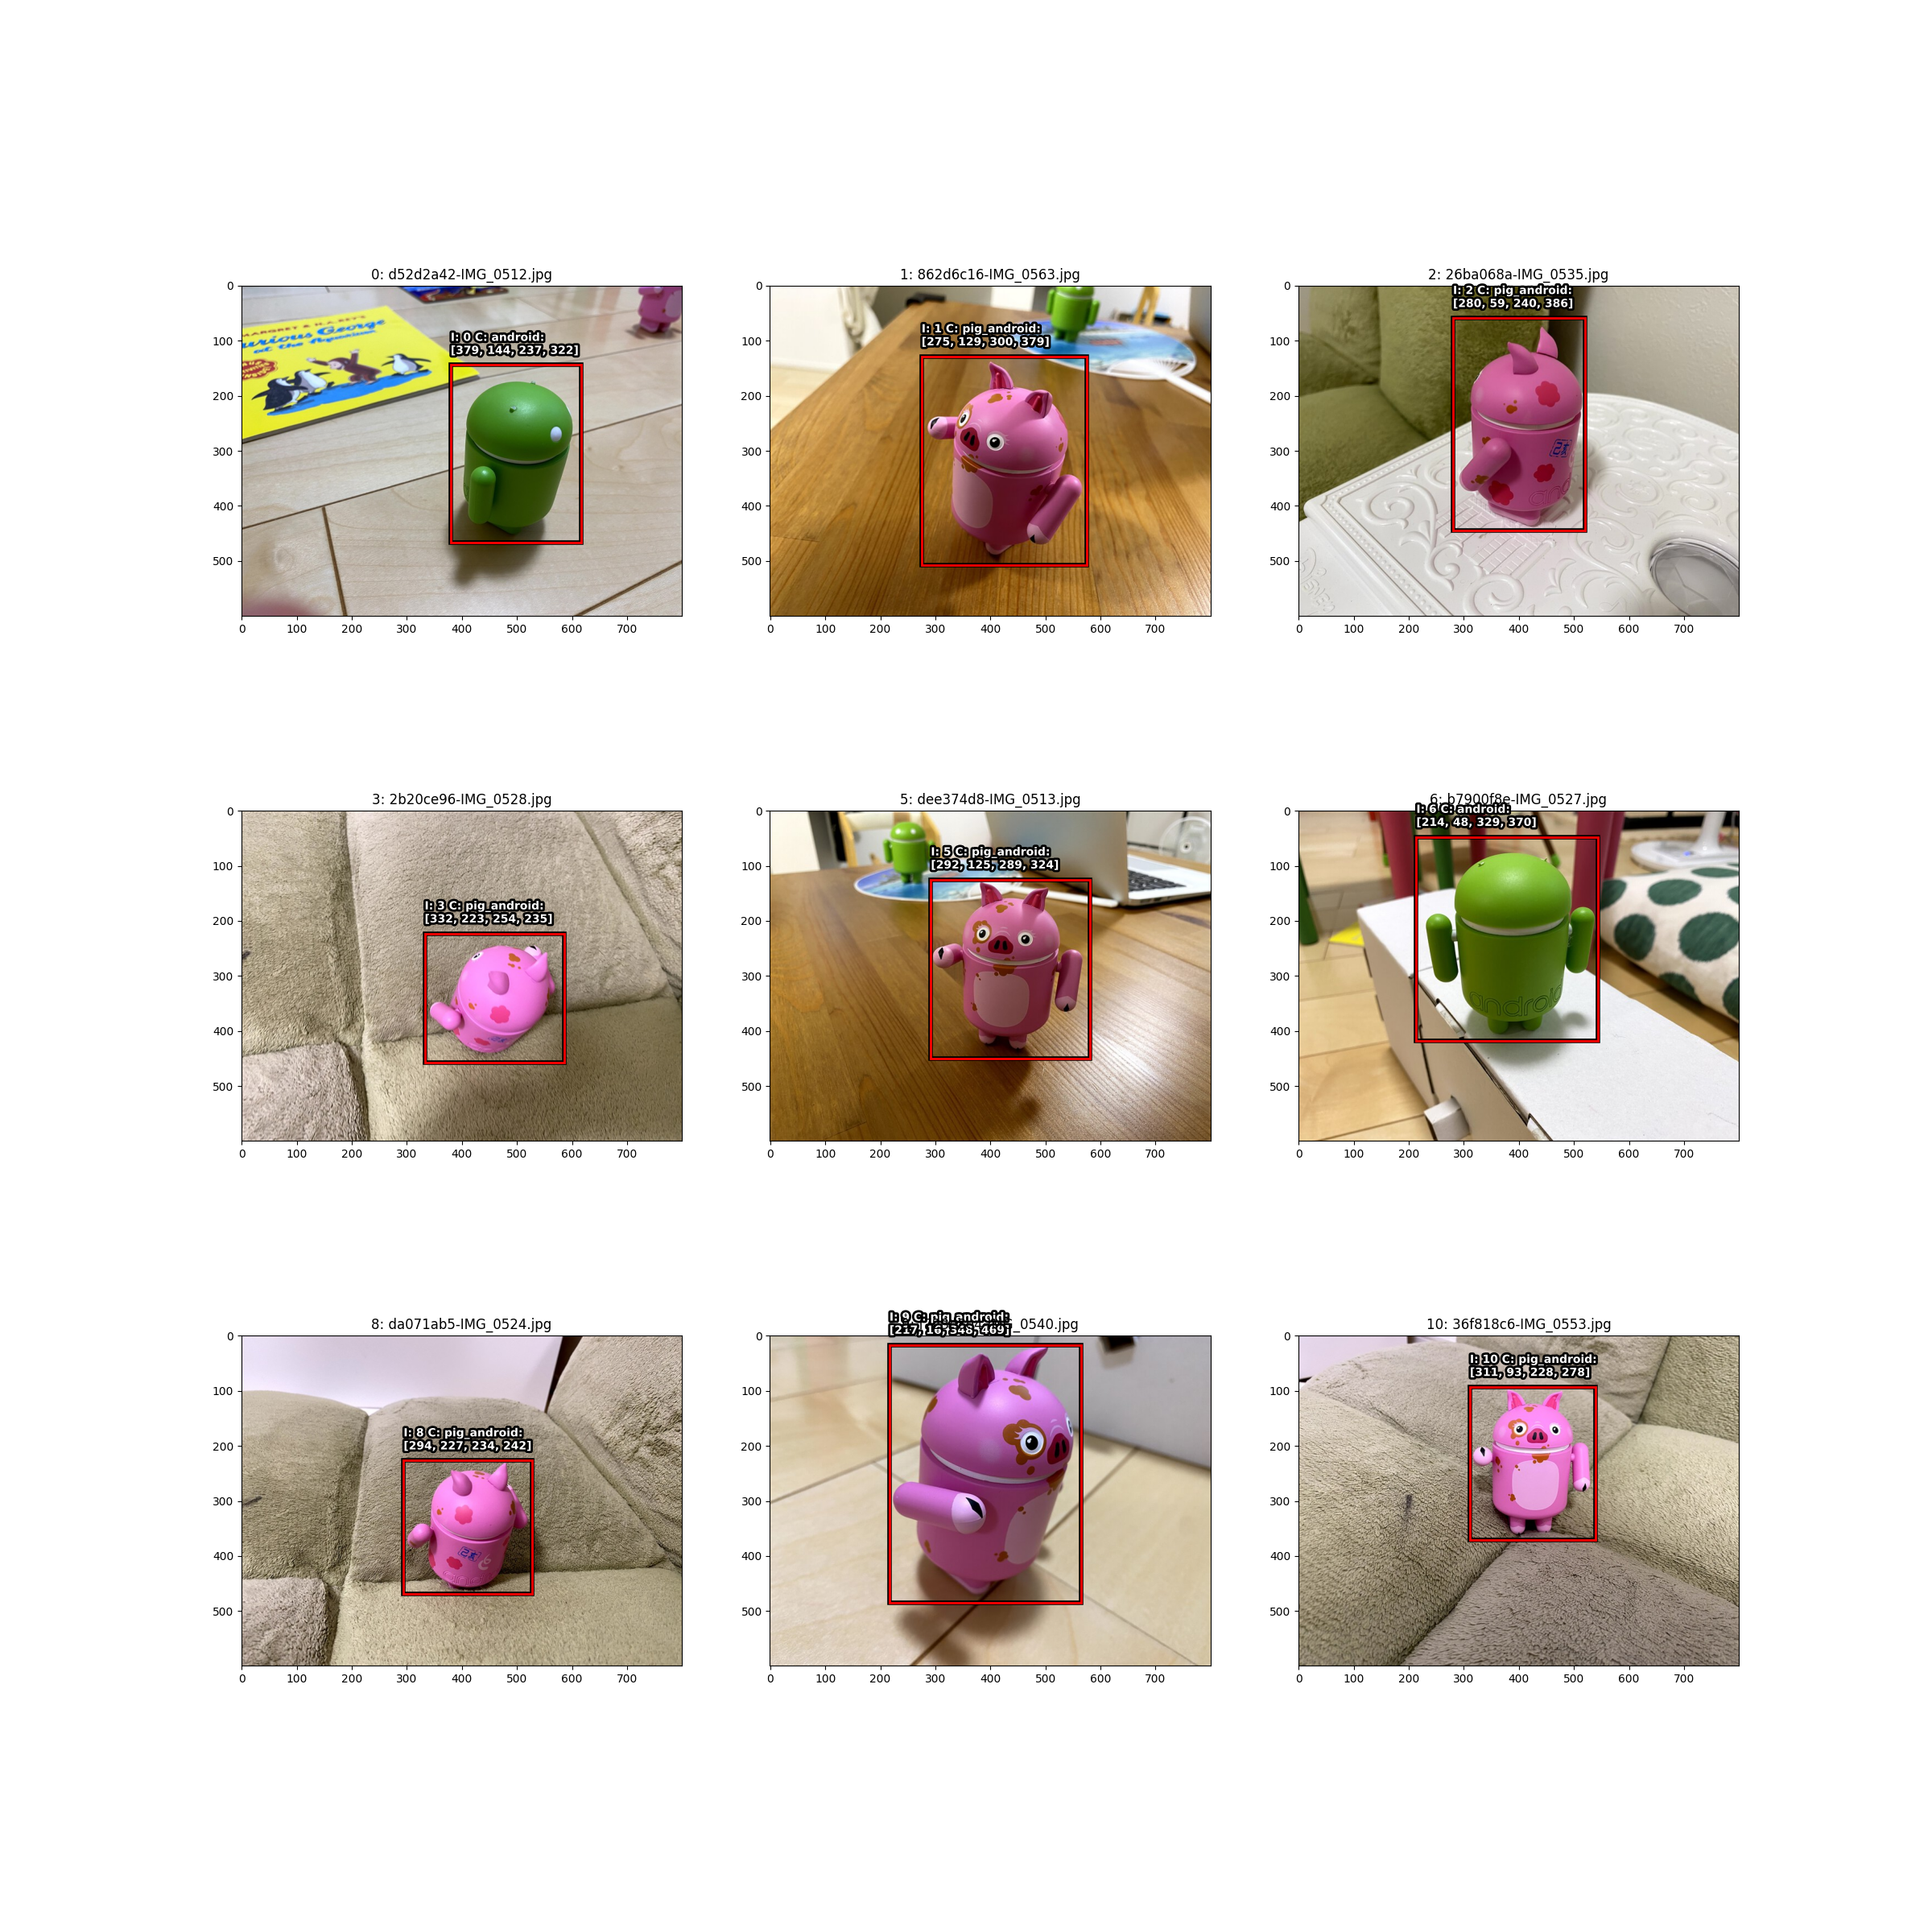

In [4]:
#@title Visualize the training dataset
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
from collections import defaultdict
import math
import os

def draw_outline(obj):
  obj.set_path_effects([patheffects.Stroke(linewidth=4,  foreground='black'), patheffects.Normal()])
def draw_box(ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  draw_outline(patch)
def draw_text(ax, bb, txt, disp):
  text = ax.text(bb[0],(bb[1]-disp),txt,verticalalignment='top'
  ,color='white',fontsize=10,weight='bold')
  draw_outline(text)
def draw_bbox(ax, annotations_list, id_to_label, image_shape):
  for annotation in annotations_list:
    cat_id = annotation["category_id"]
    bbox = annotation["bbox"]
    id = annotation["id"]
    # Format bbox values for display
    bbox_text = f"I: {id} C: {id_to_label[cat_id]}: \n[{round(bbox[0])}, {round(bbox[1])}, {round(bbox[2])}, {round(bbox[3])}]"
    draw_box(ax, bbox)
    draw_text(ax, bbox, bbox_text, image_shape[0] * 0.1)

def visualize(dataset_folder, max_examples=None, output_filename="visualization.png"):
  with open(os.path.join(dataset_folder, "labels.json"), "r") as f:
    labels_json = json.load(f)
  images = labels_json["images"]
  image_id_to_filename = {item["id"]:item["file_name"] for item in images}
  cat_id_to_label = {item["id"]:item["name"] for item in labels_json["categories"]}
  image_annots = defaultdict(list)
  for annotation_obj in labels_json["annotations"]:
    image_id = annotation_obj["image_id"]
    image_annots[image_id].append(annotation_obj)

  if max_examples is None:
    max_examples = len(image_annots.items())
  n_rows = math.ceil(max_examples / 3)
  fig, axs = plt.subplots(n_rows, 3, figsize=(24, n_rows*8)) # 3 columns(2nd index), 8x8 for each image
  for ind, (image_id, annotations_list) in enumerate(list(image_annots.items())[:max_examples]):
    ax = axs[ind//3, ind%3]
    #img = plt.imread(os.path.join(dataset_folder, "images", images[image_id]["file_name"]))
    img = plt.imread(os.path.join(dataset_folder, "images", image_id_to_filename[image_id]))
    ax.imshow(img)
    draw_bbox(ax, annotations_list, cat_id_to_label, img.shape)
    ax.set_title(f"{image_id}: " + images[image_id]["file_name"]) # Add filename as title


  plt.savefig(output_filename)
  plt.close(fig) # Close the figure to prevent it from displaying directly

visualize(train_dataset_path, 9)

from IPython.display import Image, display

display(Image(filename="visualization.png"))

### Create dataset

The Dataset class has two methods for loading in COCO or PASCAL VOC datasets:
* `Dataset.from_coco_folder`
* `Dataset.from_pascal_voc_folder`

Since the android_figurines dataset is in the COCO dataset format, use the `from_coco_folder` method to load the dataset located at `train_dataset_path` and `validation_dataset_path`. When loading the dataset, the data will be parsed from the provided path and converted into a standardized [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) format which is cached for later use. You should create a `cache_dir` location and reuse it for all your training to avoid saving multiple caches of the same dataset.

In [5]:
train_data = object_detector.Dataset.from_coco_folder(train_dataset_path, cache_dir="/tmp/od_data/train")
validation_data = object_detector.Dataset.from_coco_folder(validation_dataset_path, cache_dir="/tmp/od_data/validation")
print("train_data size: ", train_data.size)
print("validation_data size: ", validation_data.size)

train_data size:  58
validation_data size:  14


## Retrain model

Once you have completed preparing your data, you can begin retraining a model to recognize the new objects, or classes, defined by your training data. The instructions below use the data prepared in the previous section to retrain an object detection model to recognize the two types of android figurines.

### Set retraining options

There are a few required settings to run retraining aside from your training dataset: output directory for the model, and the model architecture. Use `HParams` to specify the `export_dir` parameter for the output directory. Use the `SupportedModels` class to specify the model architecture. The object detector solution supports the following model architectures:
* `MobileNet-V2`
* `MobileNet-MultiHW-AVG`

For more advanced customization of training parameters, see the  [Hyperparameters](#hyperparameters) section below.

To set the required parameters, use the following code:

In [6]:
spec = object_detector.SupportedModels.MOBILENET_MULTI_AVG
hparams = object_detector.HParams(export_dir='exported_model')
options = object_detector.ObjectDetectorOptions(
    supported_model=spec,
    hparams=hparams
)

### Run retraining
With your training dataset and retraining options prepared, you are ready to start the retraining process. This process is resource intensive and can take a few minutes to a few hours depending on your available compute resources. Using a Google Colab environment with standard GPU runtimes, the example retraining below takes about 2~4 minutes.

To begin the retraining process, use the `create()` method with dataset and options you previously defined:

In [7]:
model = object_detector.ObjectDetector.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options)

/var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/__autograph_generated_file5k_t8wyp.py:63: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(tensors).keys, (), None, fscope) if ag__.ld(n) not in ag__.ld(ref_input_names)],), None, fscope),), dict(stacklevel=2), fscope)
/var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/__autograph_generated_file5k_t8wyp.py:63: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(

Using existing files at /var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/model_maker/object_detector/mobilenetmultiavg


/Users/pierre.rossel/Documents/Projets/HEAD/2025.10 MD1 Oracle of Suits/The naked card/MediaPipeTraining/.venv311/lib/python3.11/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Model: "retina_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_net (MobileNet)      {'2': (None, 64, 64, 32   3704416   
                             ),                                  
                              '3': (None, 32, 32, 64             
                             ),                                  
                              '4': (None, 16, 16, 16             
                             0),                                 
                              '5': (None, 8, 8, 192)             
                             , '6': (None, 1, 1, 128             
                             0)}                                 
                                                                 
 fpn (FPN)                   {'5': (None, 8, 8, 128)   144928    
                             , '4': (None, 16, 16, 1             
                             28),                 

INFO:tensorflow:Training the models...


Epoch 1/30


/Users/pierre.rossel/Documents/Projets/HEAD/2025.10 MD1 Oracle of Suits/The naked card/MediaPipeTraining/.venv311/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


2025-11-05 14:04:00.317954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.
2025-11-05 14:04:00.317954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


7/7 [==============================] - 67s 3s/step - total_loss: 1.3989 - cls_loss: 1.1749 - box_loss: 0.0031 - model_loss: 1.3314 - val_total_loss: 1.3411 - val_cls_loss: 1.1671 - val_box_loss: 0.0021 - val_model_loss: 1.2737
Epoch 2/30
Epoch 2/30
7/7 [==============================] - 8s 968ms/step - total_loss: 1.3675 - cls_loss: 1.1576 - box_loss: 0.0028 - model_loss: 1.3000 - val_total_loss: 1.2514 - val_cls_loss: 1.1229 - val_box_loss: 0.0012 - val_model_loss: 1.1839
Epoch 3/30
Epoch 3/30
7/7 [==============================] - 6s 737ms/step - total_loss: 1.2540 - cls_loss: 1.0926 - box_loss: 0.0019 - model_loss: 1.1865 - val_total_loss: 1.1315 - val_cls_loss: 1.0262 - val_box_loss: 7.5572e-04 - val_model_loss: 1.0640
Epoch 4/30
Epoch 4/30
7/7 [==============================] - 6s 785ms/step - total_loss: 1.1143 - cls_loss: 0.9777 - box_loss: 0.0014 - model_loss: 1.0468 - val_total_loss: 0.9630 - val_cls_loss: 0.8625 - val_box_loss: 6.6214e-04 - val_model_loss: 0.8956
Epoch 5/30
E

### Evaluate the model performance

After training the model, evaluate it on validation dataset and print the loss and coco_metrics. The most important metric for evaluating the model performance is typically the "AP" coco metric for Average Precision.

In [8]:
loss, coco_metrics = model.evaluate(validation_data, batch_size=4)
print(f"Validation loss: {loss}")
print(f"Validation coco metrics: {coco_metrics}")

4/4 [==============================] - 6s 1s/step - total_loss: 0.2343 - cls_loss: 0.1448 - box_loss: 4.4087e-04 - model_loss: 0.1668
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.864
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.864
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.892
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.892
 Average Recall     (AR) @[

## Export model

After creating the model, convert and export it to a Tensorflow Lite model format for later use on an on-device application. The export also includes model metadata, which includes the label map.

In [9]:
model.export_model()
!ls exported_model
files.download('exported_model/model.tflite')

Exporting a floating point model


/var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/__autograph_generated_file5k_t8wyp.py:63: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(tensors).keys, (), None, fscope) if ag__.ld(n) not in ag__.ld(ref_input_names)],), None, fscope),), dict(stacklevel=2), fscope)


INFO:tensorflow:Assets written to: /var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/tmpwdkxnubg/saved_model/assets


INFO:tensorflow:Assets written to: /var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/tmpwdkxnubg/saved_model/assets
2025-11-05 14:09:18.734402: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-11-05 14:09:18.734425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 228, Total Ops 429, % non-converted = 53.15 %
 * 228 ARITH ops

- arith.constant:  228 occurrences  (f32: 224, i32: 4)



  (f32: 15)
  (f32: 2)
  (f32: 91)
  (f32: 74)
  (f32: 1)
  (f32: 2)
  (f32: 1)
  (f32: 10)
  (f32: 2)
2025-11-05 14:09:18.734402: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-11-05 14:09:18.734425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on th

INFO:tensorflow:TensorFlow Lite model exported successfully to: exported_model/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully to: exported_model/model.tflite


float_ckpt.data-00000-of-00001 metadata.json
float_ckpt.index               model.tflite
Running locally - file saved at: exported_model/model.tflite
(In Colab, this would trigger a download)
Running locally - file saved at: exported_model/model.tflite
(In Colab, this would trigger a download)


## Model quantization

Model quantization is a model modification technique that can reduce the model size and improve the speed of predictions with only a relatively minor decrease in accuracy.

This section of the guide explains how to apply quantization to your model. Model Maker supports two forms of quantization for object detector:
1. Quantization Aware Training: 8 bit integer precision for CPU usage
2. Post-Training Quantization: 16 bit floating point precision for GPU usage

### Quantization aware training (int8 quantization)
Quantization aware training (QAT) is a fine-tuning step which happens after fully training your model. This technique further tunes a model which emulates inference time quantization in order to account for the lower precision of 8 bit integer quantization. For on-device applications with a standard CPU, use Int8 precision. For more information, see the [TensorFlow Lite](https://www.tensorflow.org/model_optimization/guide/quantization/training) documentation.

To apply quantization aware training and export to an int8 model, create a `QATHParams` configuration and run the `quantization_aware_training` method. See the **Hyperparameters** section below on detailed usage of `QATHParams`.

In [10]:
qat_hparams = object_detector.QATHParams(learning_rate=0.3, batch_size=4, epochs=10, decay_steps=6, decay_rate=0.96)
model.quantization_aware_training(train_data, validation_data, qat_hparams=qat_hparams)
qat_loss, qat_coco_metrics = model.evaluate(validation_data)
print(f"QAT validation loss: {qat_loss}")
print(f"QAT validation coco metrics: {qat_coco_metrics}")

/var/folders/ym/f7pcrdz53qx13tyv9l19dyxw0000gp/T/__autograph_generated_file5k_t8wyp.py:63: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(tensors).keys, (), None, fscope) if ag__.ld(n) not in ag__.ld(ref_input_names)],), None, fscope),), dict(stacklevel=2), fscope)
/Users/pierre.rossel/Documents/Projets/HEAD/2025.10 MD1 Oracle of Suits/The naked card/MediaPipeTraining/.venv311/lib/python3.11/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/pierre.rossel/Documents/Projets/HEAD/2025.10 MD1 Oracle of Suits/The naked ca

ValueError: `to_annotate` can only be a `keras.Model` instance. Use the `quantize_annotate_layer` API to handle individual layers. You passed an instance of type: MobileNet.

The QAT step often requires multiple runs to tune the parameters of training. To avoid having to rerun model training using the `create` method, use the `restore_float_ckpt` method to restore the model state back to the fully trained float model(After running the `create` method) in order to run QAT again.

In [ ]:
new_qat_hparams = object_detector.QATHParams(learning_rate=0.9, batch_size=4, epochs=15, decay_steps=5, decay_rate=0.96)
model.restore_float_ckpt()
model.quantization_aware_training(train_data, validation_data, qat_hparams=new_qat_hparams)
qat_loss, qat_coco_metrics = model.evaluate(validation_data)
print(f"QAT validation loss: {qat_loss}")
print(f"QAT validation coco metrics: {qat_coco_metrics}")

Finally, us the `export_model` to export to an int8 quantized model. The `export_model` function will automatically export to either float32 or int8 model depending on whether `quantization_aware_training` was run.

In [ ]:
model.export_model('model_int8_qat.tflite')
!ls -lh exported_model
files.download('exported_model/model_int8_qat.tflite')

### Post-training quantization (fp16 quantization)

Post-training model quantization is a model modification technique that can reduce the model size and improve the speed of predictions with only a relatively minor decrease in accuracy. This approach reduces the size of the data processed by the model, for example by transforming 32-bit floating point numbers to 16-bit floats. Float16 quantization is reccomended for GPU usage. For more information, see the [TensorFlow Lite](https://www.tensorflow.org/model_optimization/guide/quantization/post_training) documentation.

First, import the MediaPipe Model Maker quantization module:

In [ ]:
from mediapipe_model_maker import quantization

Define a QuantizationConfig object using the `for_float16()` class method. This configuration modifies a trained model to use 16-bit floating point numbers instead of 32-bit floating point numbers. You can further customize the quantization process by setting additional parameters for the QuantizationConfig class.

In [ ]:
quantization_config = quantization.QuantizationConfig.for_float16()

Export the model using the additional quantization_config object to apply post-training quantization. Note that if you previously ran `quantization_aware_training`, you must first convert the model back to a float model by using `restore_float_ckpt`.

In [ ]:
model.restore_float_ckpt()
model.export_model(model_name="model_fp16.tflite", quantization_config=quantization_config)
!ls -lh exported_model
files.download('exported_model/model_fp16.tflite')

## Hyperparameters
You can further customize the model using the ObjectDetectorOptions class, which has three parameters for `SupportedModels`, `ModelOptions`, and `HParams`.

Use the `SupportedModels` enum class to specify the model architecture to use for training. The following model architectures are supported:
* MOBILENET_V2
* MOBILENET_V2_I320
* MOBILENET_MULTI_AVG
* MOBILENET_MULTI_AVG_I384

Use the `HParams` class to customize other parameters related to training and saving the model:
* `learning_rate`: Learning rate to use for gradient descent training. Defaults to 0.3.
* `batch_size`: Batch size for training. Defaults to 8.
* `epochs`: Number of training iterations over the dataset. Defaults to 30.
* `cosine_decay_epochs`: The number of epochs for cosine decay learning rate. See [tf.keras.optimizers.schedules.CosineDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay) for more info. Defaults to None, which is equivalent to setting it to `epochs`.
* `cosine_decay_alpha`: The alpha value for cosine decay learning rate. See [tf.keras.optimizers.schedules.CosineDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay) for more info. Defaults to 1.0, which means no cosine decay.

Use the `ModelOptions` class to customize parameters related to the model itself:
* `l2_weight_decay`: L2 regularization penalty used in [tf.keras.regularizers.L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2). Defaults to 3e-5.

Uset the `QATHParams` class to customize training parameters for Quantization Aware Training:
* `learning_rate`: Learning rate to use for gradient descent QAT. Defaults to 0.3.
* `batch_size`: Batch size for QAT. Defaults to 8
* `epochs`: Number of training iterations over the dataset. Defaults to 15.
* `decay_steps`: Learning rate decay steps for Exponential Decay. See [tf.keras.optimizers.schedules.ExponentialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) for more information. Defaults to 8
* `decay_rate`: Learning rate decay rate for Exponential Decay. See [tf.keras.optimizers.schedules.ExponentialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) for more information. Defaults to 0.96.

## Benchmarking
Below is a summary of our benchmarking results for the supported model architectures. These models were trained and evaluated on the same android figurines dataset as this notebook. When considering the model benchmarking results, there are a few important caveats to keep in mind:
* The android figurines dataset is a small and simple dataset with 62 training examples and 10 validation examples. Since the dataset is quite small, metrics may vary drastically due to variances in the training process. This dataset was provided for demo purposes and it is recommended to collect more data samples for better performing models.
* The float32 models were trained with the default HParams, and the QAT step for the int8 models was run with `QATHParams(learning_rate=0.1, batch_size=4, epochs=30, decay_rate=1)`.
* For your own dataset, you will likely need to tune values for both HParams and QATHParams in order to achieve the best results. See the [Hyperparameters](#hyperparameters) section above for more information on configuring training parameters.
* All latency numbers are benchmarked on the Pixel 6.


<table>
<thead>
<col>
<col>
<colgroup span="2"></colgroup>
<colgroup span="2"></colgroup>
<colgroup span="2"></colgroup>
<tr>
<th rowspan="2">Model architecture</th>
<th rowspan="2">Input Image Size</th>
<th colspan="2" scope="colgroup">Test AP</th>
<th colspan="2" scope="colgroup">CPU Latency</th>
<th colspan="2" scope="colgroup">Model Size</th>
</tr>
<tr>
<th>float32</th>
<th>QAT int8</th>
<th>float32</th>
<th>QAT int8</th>
<th>float32</th>
<th>QAT int8</th>
</tr>
</thead>
<tbody>
<tr>
<td>MobileNetV2</td>
<td>256x256</td>
<td>88.4%</td>
<td>73.5%</td>
<td>48ms</td>
<td>16ms</td>
<td>11MB</td>
<td>3.2MB</td>
</tr>
<tr>
<td>MobileNetV2 I320</td>
<td>320x320</td>
<td>89.1%</td>
<td>75.5%</td>
<td>75ms</td>
<td>33.38ms</td>
<td>10MB</td>
<td>3.3MB</td>
</tr>
<tr>
<td>MobileNet MultiHW AVG</td>
<td>256x256</td>
<td>88.5%</td>
<td>70.0%</td>
<td>56ms</td>
<td>19ms</td>
<td>13MB</td>
<td>3.6MB</td>
</tr>
<tr>
<td>MobileNet MultiHW AVG I384</td>
<td>384x384</td>
<td>92.7%</td>
<td>73.4%</td>
<td>238ms</td>
<td>41ms</td>
<td>13MB</td>
<td>3.6MB</td>
</tr>

</tbody>
</table>

